# Continuous Control

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environments corresponding to both versions of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

Please select one of the two options below for loading the environment.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [7]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [8]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [9]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.22399999499320983


### 4. Train the Agent

In [10]:
import random
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload

In [11]:
%autoreload 1
%aimport ddpg_agent

agent = ddpg_agent.DDPGAgent(
    state_size=state_size, action_size=action_size, num_agents=num_agents
)

In [12]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100):
    solved = False
    scores_total = []
    scores_deque = deque(maxlen=print_every)
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  # current state (for each agent)
        scores = np.zeros(num_agents)          # initialize 0 scores (for each agent)
        agent.reset()                          # initialize a random process N for action exploration
        
        for t in range(max_t):
            actions = agent.act(states)
            
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            
            agent.step(states, actions, rewards, next_states, dones)
            
            scores += rewards                                  # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            
            if np.any(dones):
                break
        
        average_episode_score = np.mean(scores)
        
        scores_deque.append(average_episode_score)
        scores_total.append(average_episode_score)
        
        average_score = np.mean(scores_deque)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score), end="")
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'actor_model.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_model.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))
        
        if average_score >= 30.0 and not solved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_score))
            solved = True
    
    torch.save(agent.actor_local.state_dict(), 'actor_model.pth')
    torch.save(agent.critic_local.state_dict(), 'critic_model.pth')
            
    return scores_total

In [ ]:
scores = ddpg(n_episodes=300, print_every=20)

Episode 20	Average Score: 1.67
Episode 40	Average Score: 5.24
Episode 60	Average Score: 5.25
Episode 80	Average Score: 7.69
Episode 100	Average Score: 16.31
Episode 120	Average Score: 19.80
Episode 140	Average Score: 25.57
Episode 155	Average Score: 30.10
Environment solved in 155 episodes!	Average Score: 30.10
Episode 160	Average Score: 31.15
Episode 180	Average Score: 33.12
Episode 200	Average Score: 31.18
Episode 220	Average Score: 32.10
Episode 240	Average Score: 31.60
Episode 260	Average Score: 34.92
Episode 280	Average Score: 33.85
Episode 300	Average Score: 34.95
Episode 320	Average Score: 35.27
Episode 340	Average Score: 35.03
Episode 360	Average Score: 35.17
Episode 380	Average Score: 35.17
Episode 400	Average Score: 34.68
Episode 420	Average Score: 34.79
Episode 437	Average Score: 35.40

In [ ]:
# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch Trained Agent

In [19]:
# load the weights from file
agent.actor_local.load_state_dict(torch.load('actor_model.pth'))
agent.critic_local.load_state_dict(torch.load('critic_model.pth'))

In [20]:
env_info = env.reset(train_mode=False)[brain_name]
states = env_info.vector_observations

for t in range(500):
    actions = agent.act(states, add_noise=False)
    env_info = env.step(actions)[brain_name]
    states = env_info.vector_observations
    dones = env_info.local_done
    if np.any(dones):
        break

When finished, you can close the environment.

In [21]:
env.close()

In [22]:
eps = np.arange(0,420,20)
avg_scores = [0, 1.67, 5.24, 5.25, 7.69, 16.31, 19.80, 25.57,
              31.15, 33.12, 31.18, 32.10, 31.60, 34.92,
              33.85, 34.95, 35.27, 35.03, 35.17, 35.17, 34.68]

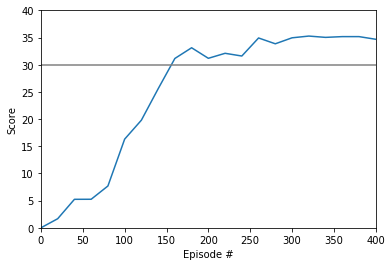

In [23]:
# Plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(eps, avg_scores)
plt.plot([0,400],[30,30],color='grey')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.axis([0,400,0,40])
plt.show()